out = (tensor([[[0., 0.]]], grad_fn=<StackBackward0>), LIFState(z=tensor([[0., 0.]], grad_fn=<CppNode<SuperFunction>>), v=tensor([[0., 0.]], grad_fn=<AddBackward0>), i=tensor([[-0.5602, -0.4316]], grad_fn=<AddBackward0>)))
out = (tensor([[[0., 0.]]]), LIFState(z=tensor([[0., 0.]]), v=tensor([[0., 0.]]), i=tensor([[-0.5602, -0.4316]])))
out = (tensor([[[0., 0.]]]), LIFState(z=tensor([[0., 0.]]), v=tensor([[0., 0.]]), i=tensor([[-0.5602, -0.4316]])))


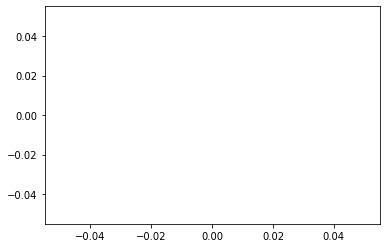

In [72]:
import torch
import norse
import torch.nn as nn
from copy import deepcopy
from collections import OrderedDict
from sys import stderr
import norse.torch as snn
from norse.torch.functional.superspike import super_fn
import math
import matplotlib.pyplot as plt
from torch import Tensor


lif_parameters = norse.torch.LIFParameters()
kappa = torch.exp(torch.tensor(-1 / 20))


class SNN(torch.nn.Module):
    def __init__(self, input_size, n_neurons, n_outputs, dt=1e-3) -> None:
        super(SNN, self).__init__()
        # self.lif_l = snn.LIFRecurrent(input_size, n_neurons, dt=dt)
        # self.l_out = torch.nn.Linear(n_neurons, n_outputs)

    # def forward(self, x):


n_inputs = 2
n_neurons = 2
n_outputs = 1
times = 1
n_batches = 1


data = torch.randn(times, n_batches, n_inputs)  # timestep, n_batches, n_features

model = SNN(n_inputs, n_neurons, n_outputs)

model(data)[0].size()
with torch.no_grad():
    plt.plot(model(data)[0][:, 0, 0].cpu().numpy())
    plt.plot(model(data)[0][:, 0, 1].cpu().numpy())

In [154]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import norse
import norse.torch as snn


device = torch.device("cpu")
# 0. prepare data
X_numpy, y_numpy = datasets.make_regression(
    n_samples=100, n_features=1, noise=20, random_state=1
)
X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32))
print(f"pre reshape y.shape = {y.size()}")
y = y.view(y.shape[0], 1)
print(f"post reshape (y.view(y.shape[0], 1)): y.shape = {y.size()}")

# 1. model (linear regression (one layer))
n_samples, n_features = X.shape
input_size = n_features
output_size = 1
kappa = np.exp(-10)


class SNNtest(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100) -> None:
        super(SNNtest, self).__init__()
        self.lif = snn.LIFRecurrent(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        out = self.lif(x)
        out = self.linear(out[0])
        return out


model = SNNtest(input_size, output_size, 1000).to(device)
# model = norse.torch.SequentialState(
#    snn.Lift(torch.nn.Linear(input_size, input_size)),
#    snn.LIFRecurrent(input_size, 1000),
#    snn.Lift(torch.nn.Linear(1000, 1))
# ).to(device)
# 2. loss and optimizer
learning_rate = 0.5
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

num_epochs = 1000
X = X.to(device)
X /= X.max()
y = y.to(device)
for epoch in range(num_epochs):
    # forward pass and loss
    y_pred = model(X)
    for i in range(1, X.shape[0], 1):
        y_pred[i] += kappa * y_pred[i - 1]
    loss = criterion(y_pred, y)
    # bacward pass
    loss.backward()

    # update
    optimizer.step()
    optimizer.zero_grad()

    # print some info
    if (epoch + 1) % 10 == 0:
        print(f"epoch: {epoch + 1}, loss = {loss.item():.4f}")

# plot
predicted = model(X)[0].detach().numpy()  # detach -- no grad?
plt.plot(X_numpy, y_numpy, "ro")
plt.plot(X_numpy, predicted, "b")
plt.show()

pre reshape y.shape = torch.Size([100])
post reshape (y.view(y.shape[0], 1)): y.shape = torch.Size([100, 1])
epoch: 10, loss = 5745.1948
epoch: 20, loss = 5745.1948
epoch: 30, loss = 5745.1948
epoch: 40, loss = 5745.1948
epoch: 50, loss = 5745.1948
epoch: 60, loss = 5745.1948
epoch: 70, loss = 5745.1948
epoch: 80, loss = 5745.1948
epoch: 90, loss = 5745.1948
epoch: 100, loss = 5745.1948
epoch: 110, loss = 5745.1948
epoch: 120, loss = 5745.1948
epoch: 130, loss = 5745.1948
epoch: 140, loss = 5745.1948
epoch: 150, loss = 5745.1948
epoch: 160, loss = 5745.1948
epoch: 170, loss = 5745.1948
epoch: 180, loss = 5745.1948


KeyboardInterrupt: 

In [9]:
import neurogym as ngym

# Enviroment
task = "PerceptualDecisionMaking-v0"
kwargs = {"dt": 100}
seq_len = 100
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=1000, seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

In [10]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import norse
import norse.torch as snn
from tqdm import tqdm

device = torch.device("cuda")


class SNNtest(torch.nn.Module):
    def __init__(self, input_size, output_size, input_weights, hidden_size=100) -> None:
        super(SNNtest, self).__init__()
        self.lif = snn.LIFRecurrent(
            input_size, hidden_size, input_weights=input_weights
        )
        # if input_weights:
        self.linear = nn.Linear(hidden_size, output_size)
        # else:
        # self.linear = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        out, _ = self.lif(x)
        out = self.linear(out)
        return out


hidden_size = 1000
input_weights = torch.rand(ob_size, hidden_size, requires_grad=True).T.to(device)
# with torch.no_grad():
# input_weights = -1 + 2 * input_weights
# input_weights *= 1
model = SNNtest(
    ob_size, act_size, input_weights=input_weights, hidden_size=hidden_size
).to(device)
for name, param in model.named_parameters():
    if name == "lif.recurrent_weights":
        prev_weights = param * 1
learning_rate = 1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# norse.torch.functional.super_fn


running_loss = 0.0
kappa = torch.exp(torch.tensor(-1 / 5, dtype=torch.float32))
for i in tqdm(range(1000)):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)

    loss = criterion(outputs.view(-1, act_size), labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
        print("{:d} loss: {:0.5f}".format(i + 1, running_loss / 100))
        running_loss = 0.0

print("Finished Training")

for name, param in model.named_parameters():
    if name == "lif.recurrent_weights":
        post_weights = param * 1

 10%|█         | 100/1000 [01:21<12:26,  1.21it/s]

100 loss: 0.81330


 11%|█         | 107/1000 [01:28<12:17,  1.21it/s]


KeyboardInterrupt: 

In [1]:
for name, param in model.named_parameters():
    print(name)
    if name == "lif.recurrent_weights":
        post_weights = param * 1

NameError: name 'model' is not defined

In [5]:
with torch.no_grad():
    print((prev_weights - post_weights) != 0).nonzero(as_tuple=True)

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]], device='cuda:0')


AttributeError: 'NoneType' object has no attribute 'nonzero'

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


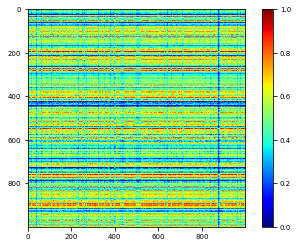

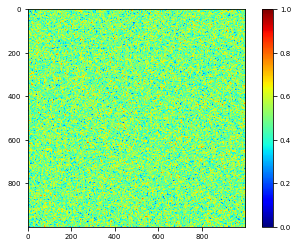

In [6]:
with torch.no_grad():
    plt.imshow((prev_weights - post_weights).cpu().numpy() > 0, cmap="jet")
    plt.colorbar()
    plt.show()
    plt.close()


with torch.no_grad():
    plt.imshow((prev_weights).cpu().numpy() > 0, cmap="jet")
    plt.colorbar()
    plt.show()

In [7]:
with torch.no_grad():
    print(((prev_weights - post_weights) != 0).nonzero(as_tuple=True))

(tensor([  0,   0,   0,  ..., 999, 999, 999], device='cuda:0'), tensor([  1,   2,   3,  ..., 996, 997, 998], device='cuda:0'))


In [8]:
for name, param in model.named_parameters():
    print(f"name:{name}")

name:lif.recurrent_weights
name:linear.weight
name:linear.bias


In [9]:
for name, param in model.named_parameters():
    print(f"name:{name}")

name:lif.recurrent_weights
name:linear.weight
name:linear.bias


In [10]:
perf = 0
num_trial = 200
from tqdm import tqdm

with torch.no_grad():
    for i in tqdm(range(num_trial)):
        env.new_trial()
        ob, gt = env.ob, env.gt
        ob = ob[:, np.newaxis, :]  # Add batch axis
        inputs = torch.from_numpy(ob).type(torch.float).to(device)

        action_pred = model(inputs)
        # action_pred = action_pred.cpu().detach().numpy()
        action_pred = torch.argmax(action_pred, axis=-1)
        perf += (gt[-1] == action_pred[-1, 0]).cpu().item()

    perf /= num_trial
    print("Average performance in {:d} trials".format(num_trial))
    print(perf)

100%|██████████| 200/200 [00:00<00:00, 333.53it/s]

Average performance in 200 trials
0.68


In [18]:
import neurogym as ngym

# Enviroment
task = "PerceptualDecisionMaking-v0"
kwargs = {"dt": 100}
seq_len = 200  # times
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=100, seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n
inputs, labels = dataset()
indexes_positive = np.argwhere(labels != 0)
indexes_positive[0]

array([21,  0])

  0%|          | 0/1000 [00:00<?, ?it/s]


ValueError: could not broadcast input array from shape (100,) into shape (0,)

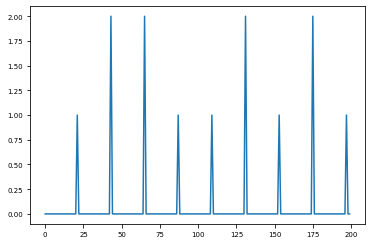

In [19]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import norse
import norse.torch as snn
from tqdm import tqdm

device = torch.device("cuda")


class SNNtest(torch.nn.Module):
    def __init__(self, input_size, output_size, input_weights, hidden_size=100) -> None:
        super(SNNtest, self).__init__()
        self.lif = snn.LIFRecurrent(
            input_size, hidden_size, input_weights=input_weights
        )
        # if input_weights:
        self.linear = nn.Linear(hidden_size, output_size)
        # else:
        # self.linear = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        out, _ = self.lif(x)
        out = self.linear(out)
        return out


hidden_size = 1000
input_weights = torch.rand(ob_size, hidden_size, requires_grad=True).T.to(device)
# with torch.no_grad():
# input_weights = -1 + 2 * input_weights
# input_weights *= 1
model = SNNtest(
    ob_size, act_size, input_weights=input_weights, hidden_size=hidden_size
).to(device)
for name, param in model.named_parameters():
    if name == "lif.recurrent_weights":
        prev_weights = param * 1
learning_rate = 1e-1
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# norse.torch.functional.super_fn

inputs, labels = dataset()
# plt.plot(inputs[:, 0, 0])
# plt.plot(inputs[:, 0, 1])
# plt.plot(inputs[:, 0, 2])
plt.plot(labels[:, 0])
labels_new = labels * 1
indexes_positive = np.argwhere(labels_new != 0)


inputs, labels = dataset()
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
learning_outputs = model(inputs)

running_loss = 0.0
kappa = torch.exp(torch.tensor(-1 / 5, dtype=torch.float32))
for i in tqdm(range(1000)):
    inputs, labels = dataset()
    indexes_positive = np.argwhere(labels != 0)
    for j in range(1, len(indexes_positive)):
        prev_index = indexes_positive[j - 1][0]
        curent_index = indexes_positive[j][0]
        labels[prev_index:curent_index, 0] = labels[curent_index]  # one dim
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
    with torch.no_grad():
        learning_outputs[:, :, (labels.cpu().numpy() - 1)] = 1
        learning_outputs[:, :, 0] = inputs[:, :, 0]
    learning_outputs = learning_outputs.detach()
    # learning_outputs[]

    # forward + backward + optimize
    outputs = model(inputs)

    loss = criterion(outputs, learning_outputs)
    loss.backward()
    optimizer.step()
    # zero the parameter gradients
    optimizer.zero_grad()
    # print statistics
    running_loss += loss.item()
    if i % 100 == 99:
        print("yes")
        print("{:d} loss: {:0.5f}".format(i + 1, running_loss / 100))
        running_loss = 0.0

print("Finished Training")

for name, param in model.named_parameters():
    if name == "lif.recurrent_weights":
        post_weights = param * 1

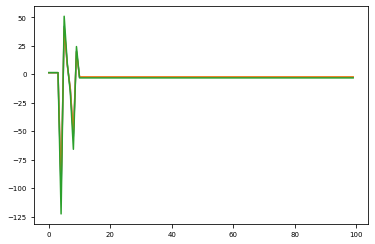

In [10]:
outputs_for_plot = outputs.detach().cpu().numpy()
plt.plot(outputs_for_plot[:, 0, 0])
plt.plot(outputs_for_plot[:, 0, 1])
plt.plot(outputs_for_plot[:, 0, 2])

In [272]:
inputs.shape

torch.Size([500, 1, 3])

tensor([[[-0.7591, -0.7591, -0.7591,  ..., -0.7591, -0.7591, -0.7591]],

        [[-0.7591, -0.7591, -0.7591,  ..., -0.7591, -0.7591, -0.7591]],

        [[-0.7591, -0.7591, -0.7591,  ..., -0.7591, -0.7591, -0.7591]],

        ...,

        [[-1.3100, -1.3100, -1.3100,  ..., -1.3100, -1.3100, -1.3100]],

        [[-1.2874, -1.2874, -1.2874,  ..., -1.2874, -1.2874, -1.2874]],

        [[-1.3927, -1.3927, -1.3927,  ..., -1.3927, -1.3927, -1.3927]]],
       device='cuda:0', grad_fn=<IndexBackward0>)

In [260]:
inputs.shape

torch.Size([500, 1, 3])

In [17]:
inputs, labels = dataset()
print(f'size labels = {labels.shape}')
for i in range(labels.shape[1]):
    if (labels[:, i] == 1).index()


size labels = (100, 160)


In [67]:
print(f"size labels = {labels.shape}")

size labels = (100, 160)


In [40]:
(labels[21, :] == 1)

array([ True,  True, False, False, False,  True, False, False, False,
        True,  True, False, False,  True, False,  True,  True, False,
        True, False, False,  True, False, False,  True, False, False,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False, False,  True,  True,  True,  True, False,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
        True, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True,

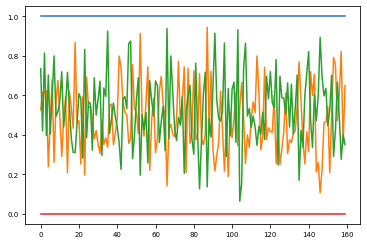

In [65]:
index = 26

plt.plot(inputs[index, :, 0])
plt.plot(inputs[index, :, 1])
plt.plot(inputs[index, :, 2])
plt.plot(labels[index, :])

In [230]:
import neurogym as ngym

# Enviroment
task = "PerceptualDecisionMaking-v0"
kwargs = {"dt": 100}
seq_len = 100  # times
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=1, seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n

inputs.shape = (100, 1, 3)
 labels.shape = (100, 1)


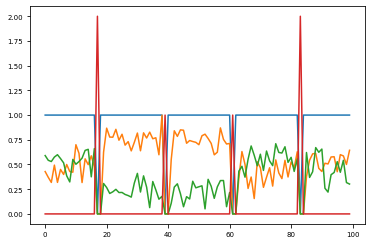

In [237]:
inputs, labels = dataset()
print(f"inputs.shape = {inputs.shape}\n labels.shape = {labels.shape}")

plt.plot(inputs[:, 0, 0])
plt.plot(inputs[:, 0, 1])
plt.plot(inputs[:, 0, 2])
plt.plot(labels[:, 0])

torch.Size([500, 1, 3])

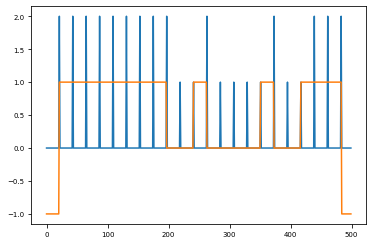

In [251]:
import neurogym as ngym

# Enviroment
task = "PerceptualDecisionMaking-v0"
kwargs = {"dt": 100}
seq_len = 500  # times
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=1, seq_len=seq_len)
env = dataset.env
ob_size = env.observation_space.shape[0]
act_size = env.action_space.n
inputs, labels = dataset()
# plt.plot(inputs[:, 0, 0])
# plt.plot(inputs[:, 0, 1])
# plt.plot(inputs[:, 0, 2])
plt.plot(labels[:, 0])
labels_new = labels * 1
indexes_positive = np.argwhere(labels_new != 0)
for i in range(1, len(indexes_positive)):
    prev_index = indexes_positive[i - 1][0]
    curent_index = indexes_positive[i][0]
    labels_new[prev_index:curent_index, 0] = labels_new[curent_index]  # one dim
plt.plot(labels_new[:, 0] - 1)
inputs = torch.from_numpy(inputs).type(torch.float).to(device)

outputs = model(inputs)
outputs.size()

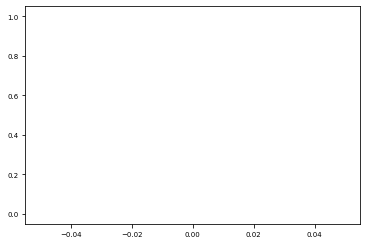

In [233]:
index = 0

plt.plot(inputs[index, :, 0])
plt.plot(inputs[index, :, 1])
plt.plot(inputs[index, :, 2])
plt.plot(labels[index, :])

In [127]:
labels = torch.from_numpy(labels.flatten()).type(torch.long).to(device)
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

(100, 1)